In [15]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE = 32
NUM_WORKERS = int(os.cpu_count() / 2)

In [16]:
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS


class MNISTDataModule(pl.LightningDataModule):
    def __init__(
        self, data_dir="../data", batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(root=self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(
                root=self.data_dir, train=False, transform=self.transform
            )

    def train_dataloader(self):
        return DataLoader(
            dataset=self.mnist_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.mnist_val,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.mnist_test,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

In [17]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [18]:
# Generator Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7 * 7 * 64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)  # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)  # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  # 256

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [19]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        # random noise
        self.validation_z = torch.randn(8, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    @staticmethod
    def adversarial_loss(y_hat, y):
        return F.binary_cross_entropy_with_logits(y_hat, y)

    def training_step(self, batch):
        imgs, _ = batch

        opt_g, opt_d = self.optimizers()

        # sample noise
        z = torch.randn(
            imgs.shape[0], self.hparams.latent_dim
        )  # imgs.shape[0] is the batch size
        z = z.type_as(imgs)

        # Train generator
        # ground truth result (ie: all fake)
        # put on GPU because we created this tensor inside training_loop
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        self.toggle_optimizer(opt_g)
        # adversarial loss is binary cross-entropy
        g_loss = self.adversarial_loss(
            self.discriminator(self(z)), valid
        )  # how well can it learn to generate real data? (try to fool the detective)
        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()
        self.untoggle_optimizer(opt_g)

        # Train discriminator
        # Measure discriminator's ability to classify real from generated samples
        # how well can it label as real?
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        self.toggle_optimizer(opt_d)
        real_loss = self.adversarial_loss(self.discriminator(imgs), valid)

        # how well can it label as fake?
        fake = torch.zeros(imgs.size(0), 1)
        fake = fake.type_as(imgs)

        fake_loss = self.adversarial_loss(self.discriminator(self(z).detach()), fake)

        # discriminator loss is the average of these
        d_loss = (real_loss + fake_loss) / 2

        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()
        self.untoggle_optimizer(opt_d)

        self.log_dict({"d_loss": d_loss, "g_loss": g_loss})

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []

    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        # log sampled images
        sample_imgs = self(z)
        plt.figure(figsize=(8, 4))
        for i, img in enumerate(sample_imgs):
            plt.subplot(2, 4, i + 1)
            plt.imshow(img.squeeze().detach().cpu(), cmap="gray")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    def on_train_epoch_end(self):
        self.plot_imgs()

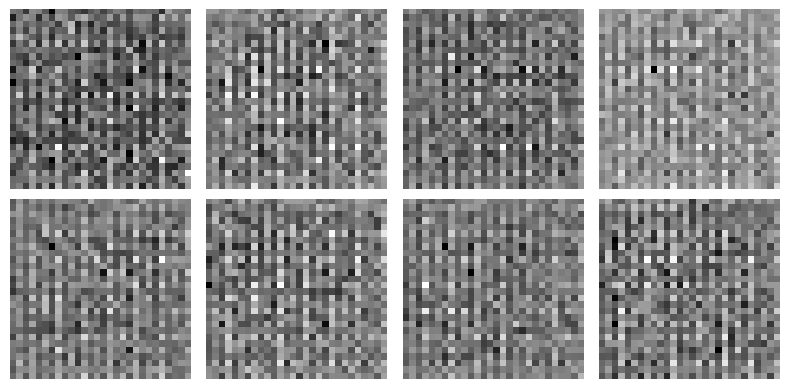

In [20]:
dm = MNISTDataModule()
dm.prepare_data()
dm.setup()

model = GAN()
model.plot_imgs()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

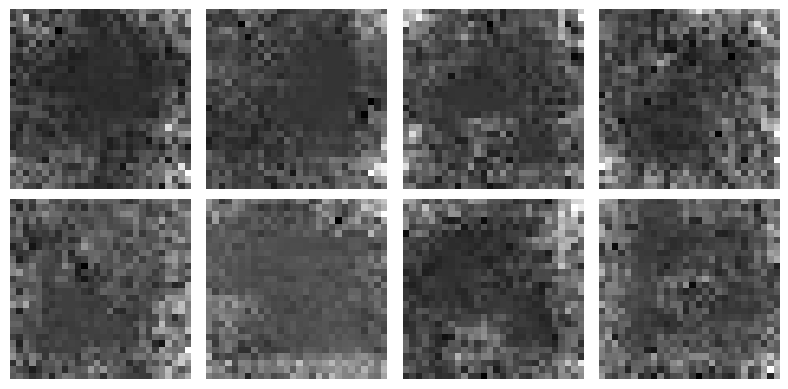

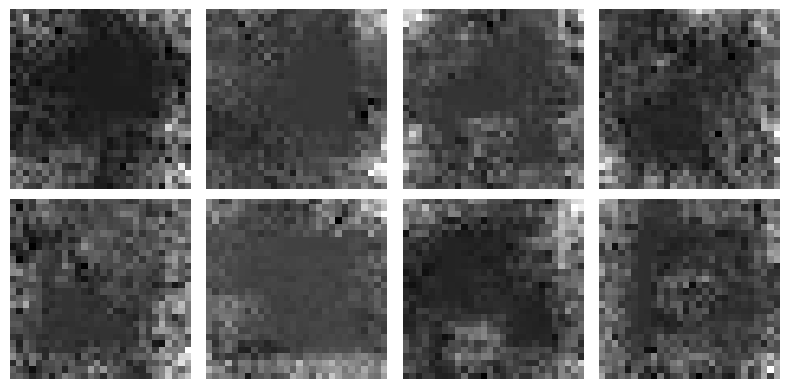

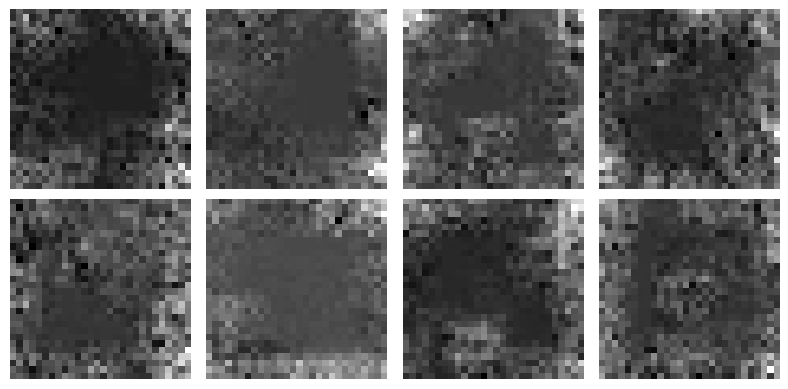

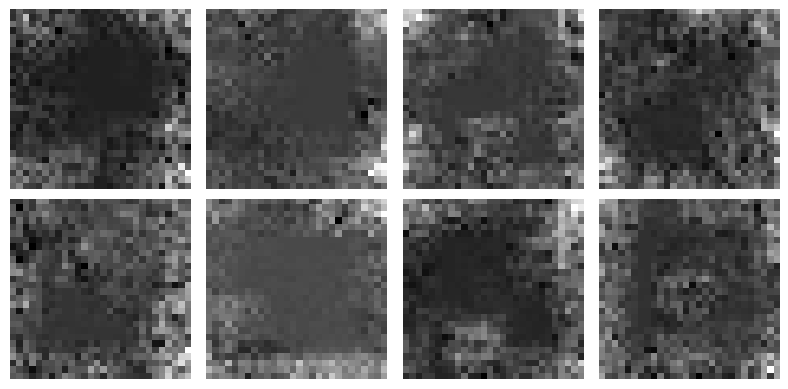

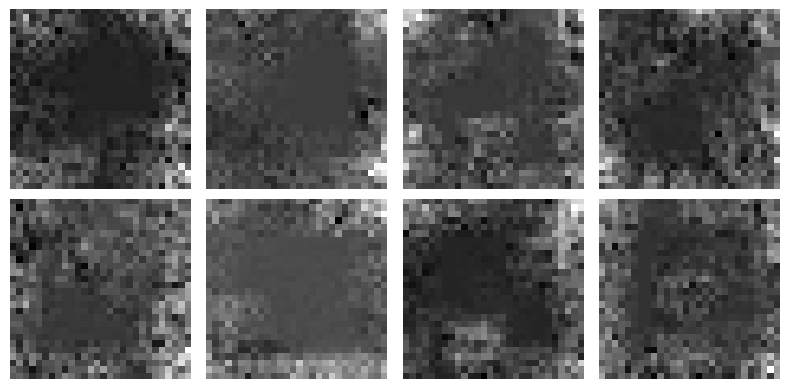

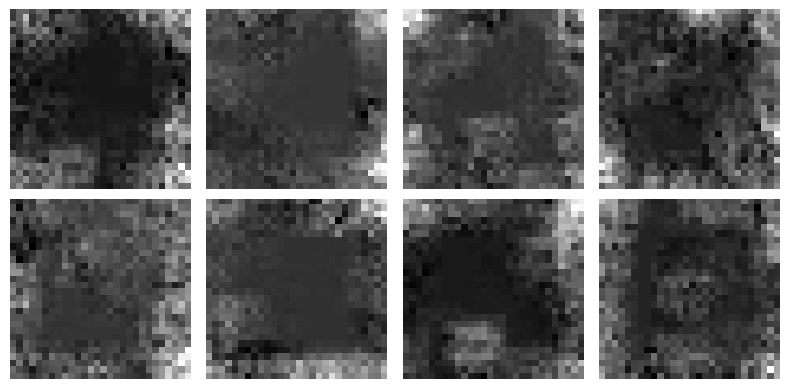

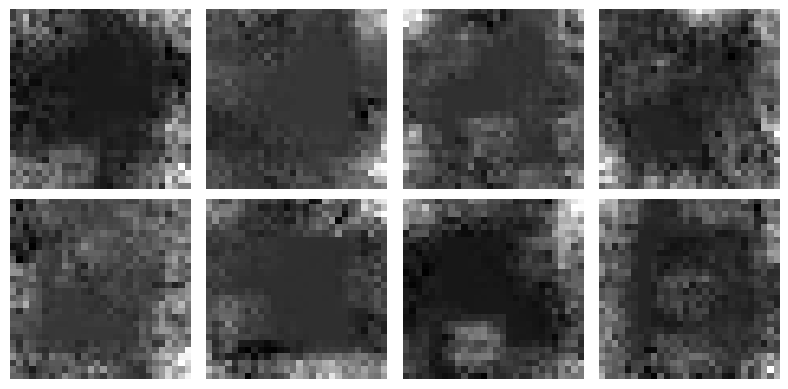

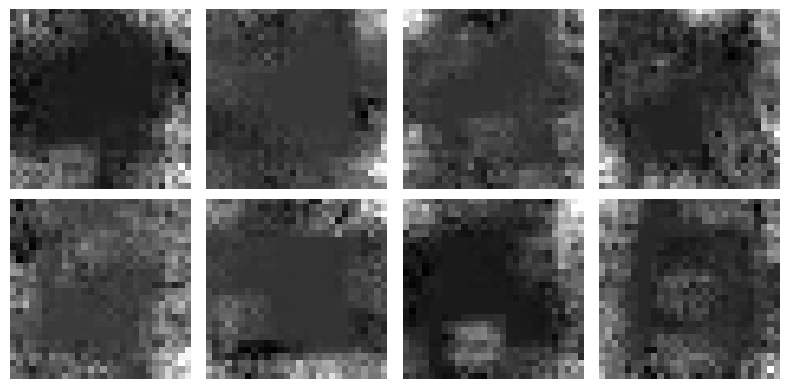

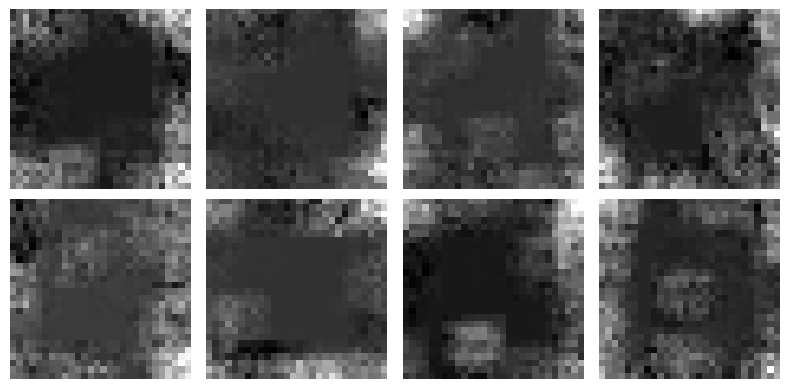

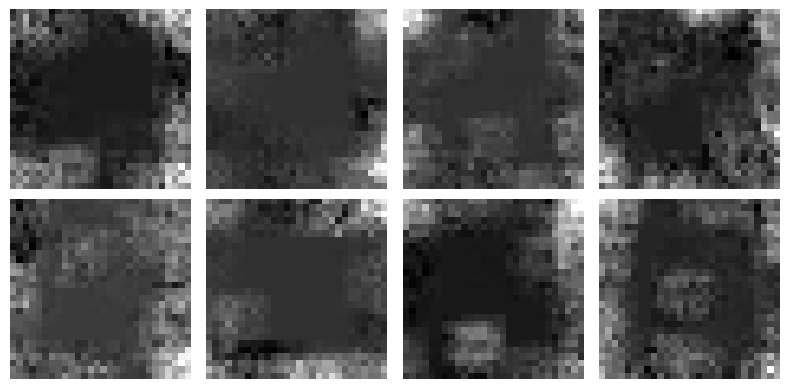

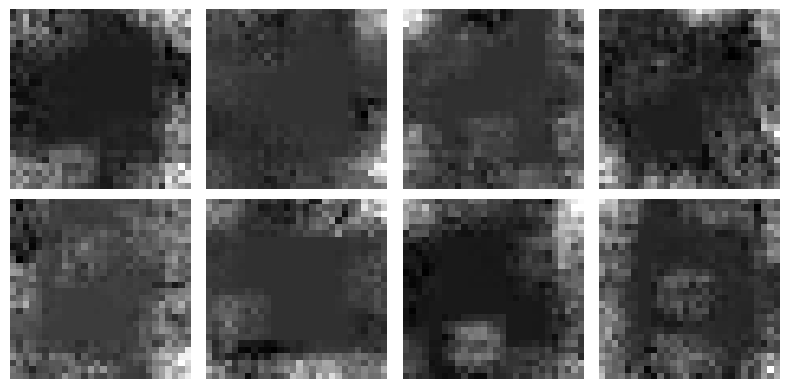

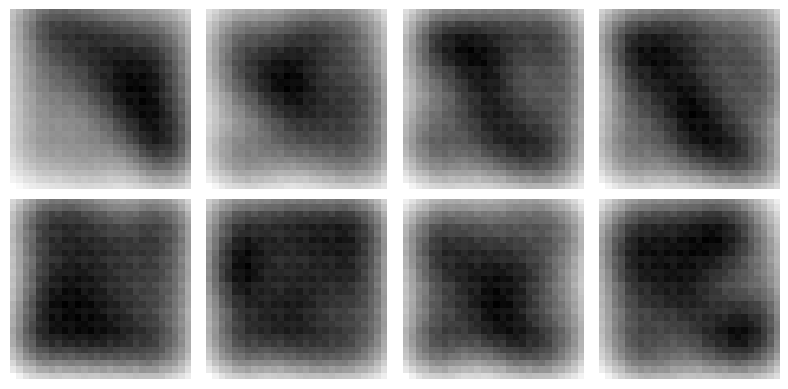

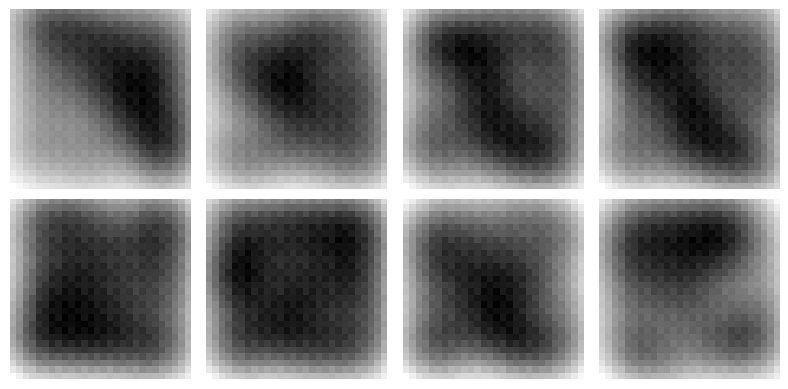

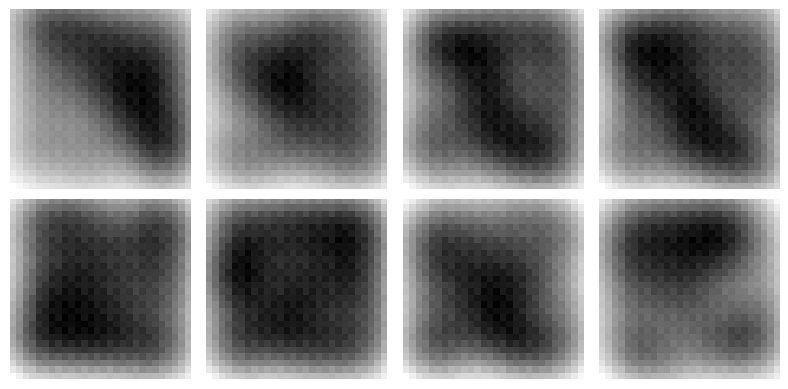

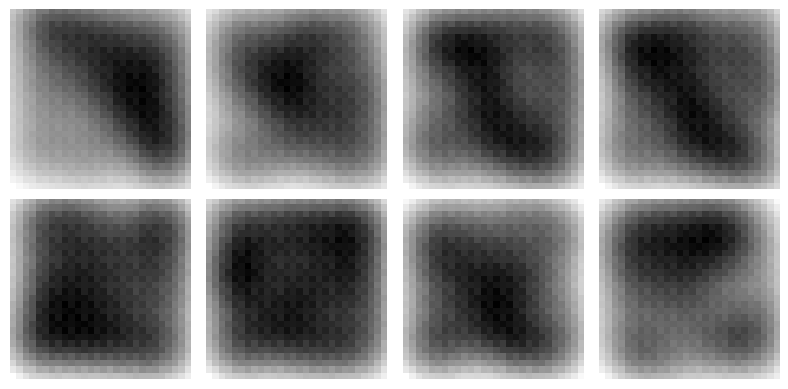

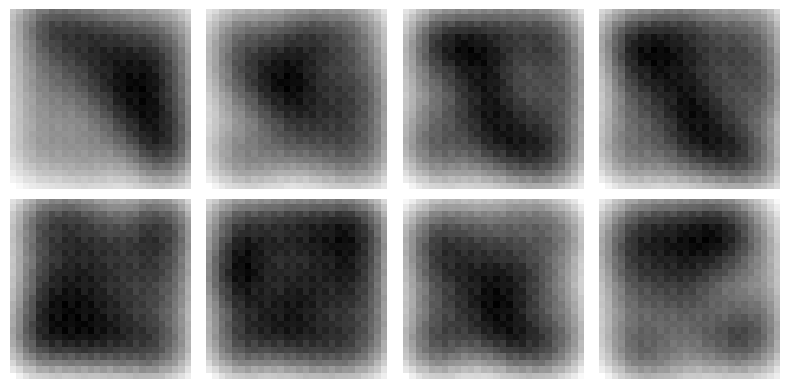

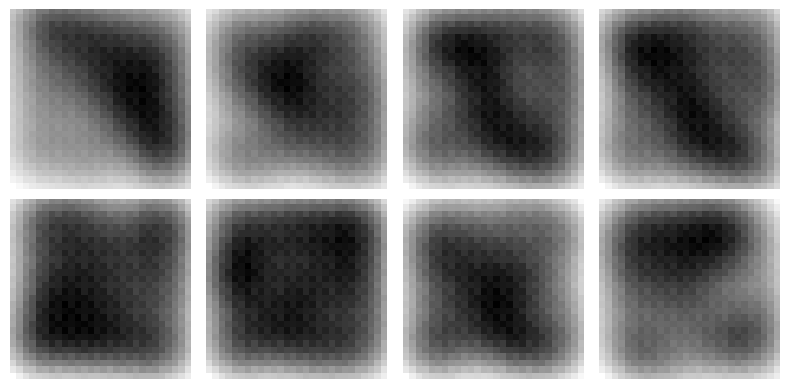

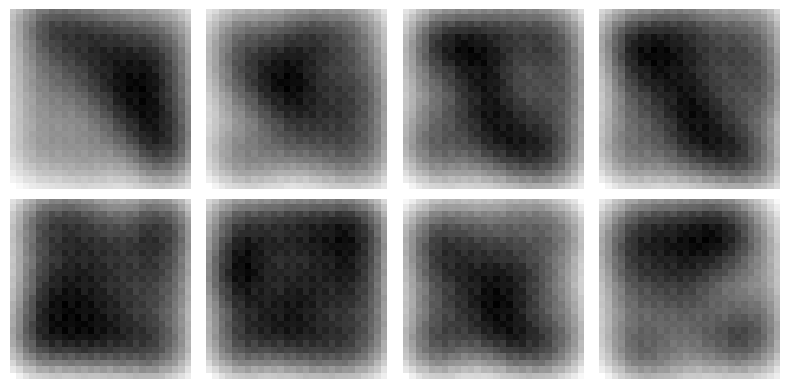

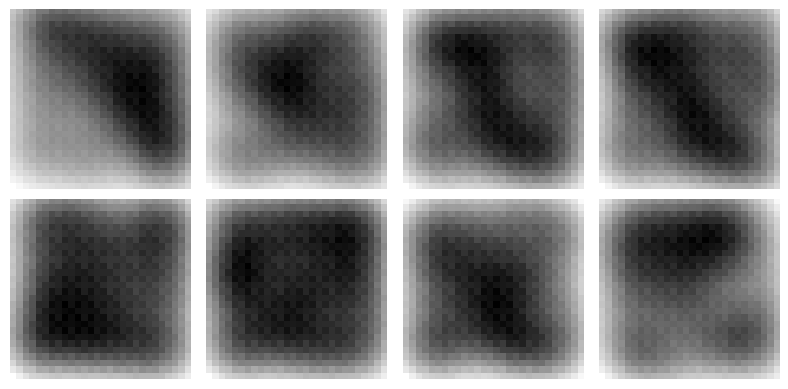

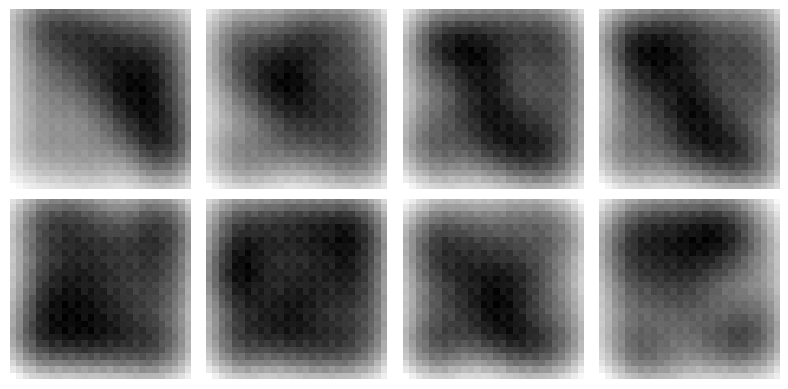

`Trainer.fit` stopped: `max_epochs=20` reached.


In [21]:
trainer = pl.Trainer(max_epochs=20, accelerator="gpu", devices=1)
trainer.fit(model, train_dataloaders=dm)